In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Nonogram(): 
    """ Class for creating and solving Nonograms """

    class Variable():
        """ Class for generating CSP variables """
        def __init__(self, row, index, value, num_of_cols):
            self.row = row
            self.index = index
            self.value = value
            self.domain = [i for i in range(num_of_cols)]
            self.final_value = None

    class Constraint():
        """ Class for generating CSP constraints """
        def __init__(self, col, index, value):
            self.col = col
            self.index = index
            self.value = value                   
            self.remaining = value    

    def __init__(self, folder):
        """ Constructor of Nonogram objects """

        # Reading the data
        row_data = pd.read_excel(f"Crosswords/{folder}/Rows.xlsx", header=None)
        row_data.fillna("", inplace=True)
        self.row_matrix = np.asarray([list(row.values) for index, row in row_data.iterrows()])

        col_data = pd.read_excel(f"Crosswords/{folder}/Columns.xlsx", header=None)
        col_data.fillna("", inplace=True)
        self.col_matrix = np.asarray([list(row.values) for index, row in col_data.iterrows()])

        # Creating a matrix for keeping the solution
        self.final_matrix = [["" for j in range(len(self.col_matrix[0]))] for i in range(len(self.row_matrix))]
        self.full_matrix = []
        self.build_full_matrix()


        # CSP Formulation and domain adjustment
        self.variables = []
        self.constraints = [[] for _ in range(len(self.col_matrix[0]))]
        self.formulate_csp()


    def build_full_matrix(self):
        """ Method for connecting constraint matrices with the field that will include the solution """
        self.full_matrix = []

        for row in self.col_matrix:
            self.full_matrix.append(["///" for _ in range(len(self.row_matrix[0]))] + list(row))

        for i in range(len(self.row_matrix)):
            self.full_matrix.append(list(self.row_matrix[i]) + self.final_matrix[i])

    
    def draw(self):
        """ Method for visualising the board """
        A = self.full_matrix
        
        m = len(A)-1
        n = len(A[0])-1

        plt.figure(figsize=(n/1.5, m/1.5))
        for krow, row in enumerate(A):
            for kcol, num in enumerate(row):
                plt.text(10*kcol + 5, 10*krow + 5, str(num).split(".")[0],
                        horizontalalignment='center',
                        verticalalignment='center',
                        backgroundcolor="Black" if num == "///" else "White",
                        size=12 if num != "///" else 18,
                        color="Black")


        plt.axis([0, 10*(n + 1), 10*(m + 1), 0])
        plt.xticks(np.linspace(0, 10*(n + 1), n + 2), [])
        plt.yticks(np.linspace(0, 10*(m + 1), m + 2), [])
        plt.grid(linestyle="solid", linewidth=2)

        plt.savefig("Figure.png")
        plt.show()


    def print_domains(self):
        """ Method for prinitng the current domain of each variable """
        for r in range(len(self.variables)):
            row = self.variables[r]
            for i in range(len(row)):
                print(r, i, row[i].domain)


    def print_solution(self):
        """ Method for prinitng the final value assigned to variable """
        for r in range(len(self.variables)):
            row = self.variables[r]
            for i in range(len(row)):
                print(r, i, "-", row[i].final_value)

    def crop_variables(self, variables):
        """ Method for removing impossible values from domains """
        # Removing values from domains to fit constraints
        for row in variables:
            for i in range(len(row)):                
                # Constraints not to let the block get out of the grid 
                crop_from_right = row[i].value-1

                # Constraints to leave free space for other blocks
                for j in range(i+1, len(row)):
                    crop_from_right += row[j].value + 1

                crop_from_left = 0
                for j in range(i-1, -1, -1):
                    crop_from_left += row[j].value + 1
    
                # Removing prohibitted values from the 2 constraints mentioned above
                if crop_from_right != 0:
                    row[i].domain = row[i].domain[:-crop_from_right]

                if crop_from_left != 0:
                    row[i].domain = row[i].domain[crop_from_left:]


    def formulate_csp(self):
        """ Method for creating the variables and defining main constraints """
        # Adding all variables with initial domain
        for i in range(len(self.row_matrix)):
            self.variables.append([self.Variable(i, None, int(str(self.row_matrix[i][j]).split(".")[0]), len(self.col_matrix[0])) for j in range(len(self.row_matrix[0])) if self.row_matrix[i][j] != ""])
        for i in range(len(self.variables)):
            for j in range(len(self.variables[i])):
                self.variables[i][j].index = j
        self.crop_variables(self.variables)

        # Add column color counter as constraint
        for j in range(len(self.col_matrix[0])):
            current_col = self.col_matrix[:,j]

            for val in current_col:
                if val != "":
                    self.constraints[j].append(self.Constraint(j, len(self.constraints[j]), int(val.split(".")[0])))


    def search(self, assigned, unassigned):    
        """ Backtracking search with forward checking and constraint enforcement """
        if len(unassigned) == 0:
            return assigned

        current = unassigned.pop(0)
        for val in current.domain:
            is_consistent = True
            changed_constraints = []
            covered_cells = [pos for pos in range(val, val+current.value)]

            for index in current.domain:
                if index < val:
                    for const in self.constraints[index]:
                        if const.remaining != 0 and const.remaining < const.value:
                            is_consistent = False

            if current == self.variables[current.row][-1]:
                for cell in range(val+1, len(self.col_matrix[0])):
                    if cell not in covered_cells:
                        for const in self.constraints[cell]:
                            if const.remaining != 0 and const.remaining < const.value:
                                is_consistent = False

            if is_consistent:
                is_consistent = False
                for const in  self.constraints[val]:
                    if const.remaining != 0:
                        const.remaining -= 1    
                        changed_constraints.append(const)  # Revert when bactrack
                        is_consistent = True
                        break

            if is_consistent:
                for cell in covered_cells:
                    if cell != val:
                        for const in self.constraints[cell]:
                            check = False
                            if const.remaining != 0:
                                const.remaining -= 1    
                                changed_constraints.append(const)  # Revert when bactrack
                                check = True
                                break
                        if check == False:
                            is_consistent = False

            if is_consistent:
                assigned.append(current)
                current.final_value = val

                # Adding inferences
                removed = dict()
                for var in self.variables[current.row]:
                    if var != current:
                        removed[var] = [pos for pos in var.domain if pos in covered_cells or (self.variables[current.row].index(var) > current.index and pos < current.final_value)]   # Revert when bactrack
                        if val+1 in var.domain:
                            removed[var].append(val+1)
                        var.domain = [pos for pos in var.domain if pos not in removed[var]]

                if current.row != len(self.variables)-1:
                    for const in changed_constraints:
                        if const.remaining == 0:
                            index = const.col
                            for var in self.variables[current.row+1]:
                                if index in var.domain:
                                    if var in removed.keys():
                                        removed[var].append(index)
                                    else:
                                        removed[var] = [index]
                                    var.domain = [pos for pos in var.domain if pos not in removed[var]]

                is_failure = False
                for var in removed.keys():
                    if len(var.domain) == 0:
                        is_failure = True
                        break
                
                if not is_failure:
                    result = self.search(assigned, unassigned)
                    if result != "FAILURE":
                        return result

                for var in removed.keys():
                    var.domain += removed[var]
                    var.domain = sorted(set(var.domain))

                for const in changed_constraints:
                    const.remaining += 1

                assigned.pop()
                current.final_value = None

            else:
                for const in changed_constraints:
                    const.remaining += 1

        unassigned.insert(0, current)

        return "FAILURE"

    def solve(self):
        """ Method for starting backtracking search """
        unassigned = [x for xs in self.variables for x in xs]

        self.search([], unassigned)

        for row in self.variables:
            for var in row:
                for cell in range(var.final_value, var.final_value+var.value):
                    self.final_matrix[var.row][cell] = "///"

        self.build_full_matrix()
        self.draw()

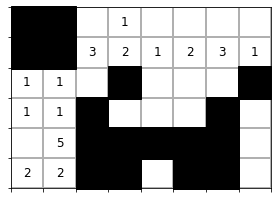

In [3]:
N = Nonogram("Sample")
N.solve()